In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from torch.utils.data import random_split

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

from PIL import Image
import os
import glob
import matplotlib.pyplot as plt

import time

In [2]:
data_path_train = "/Users/pranavi/Downloads/train"

In [3]:
data_path_test = "/Users/pranavi/Downloads/test1"

In [4]:
img_size = 120

In [5]:
train_list = glob.glob(os.path.join(data_path_train,"*.jpg"))

In [6]:
train_list[0]

'/Users/pranavi/Downloads/train/dog.8011.jpg'

In [7]:
train_list = train_list[:10000]

In [8]:
img_transform = transforms.Compose([transforms.Resize((img_size,img_size)),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean = [0.485,0.456, 0.406], std=[0.229, 0.224,0.225])])

In [9]:
class custom_dataset(Dataset):
    def __init__(self, file_list, transform):
    
        self.file_list = file_list
        self.transform = transform
    
    def __getitem__(self,index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        img_transform = self.transform(img)
        
        label = img_path.split("/")[-1].split(".")[0]
        if label == "cat":
            label = 0
        elif label == "dog":
            label = 1
        return img_transform, label
    
    def __len__(self):
        return(len(self.file_list))

In [10]:
train_data = custom_dataset(train_list, img_transform)

In [11]:
len(train_data)

10000

In [12]:
train_df, val_df = random_split(train_data, [9000,1000])

In [13]:
len(train_df)

9000

In [14]:
train_loader = DataLoader(train_df, batch_size=68, shuffle=True)
test_loader = DataLoader(val_df, batch_size=68, shuffle=False)

In [16]:
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

torch.Size([68, 3, 120, 120]) torch.Size([68])


In [17]:
#generator(memory management)
dataiter = iter(train_loader)
images, labels = dataiter.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


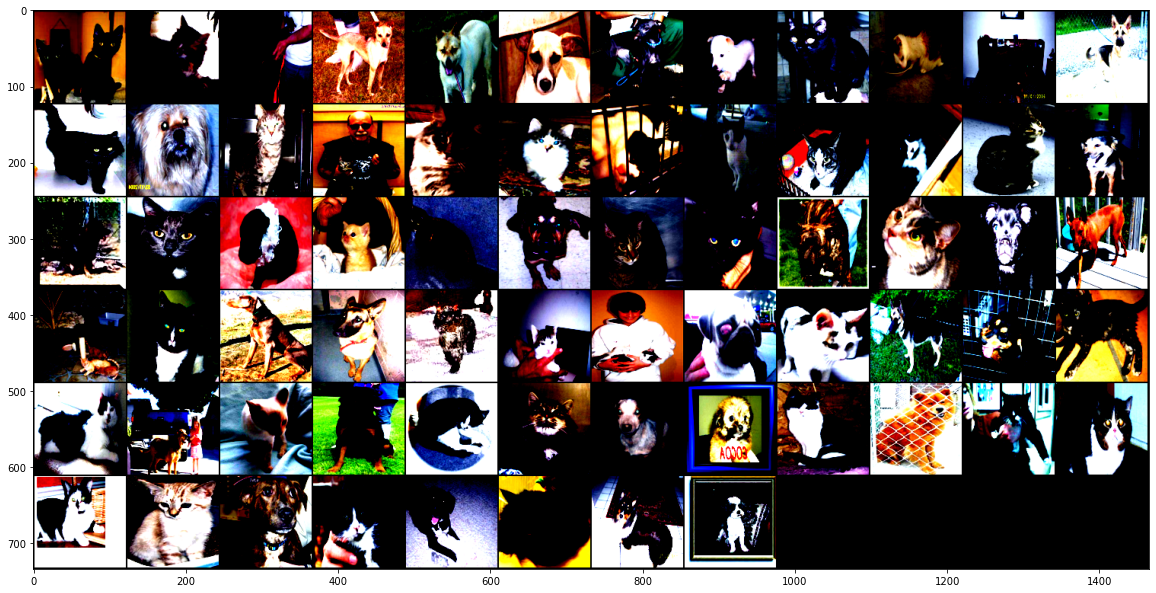

In [18]:
for images, labels in train_loader:
    plt.figure(figsize=(20,15))
    plt.imshow(make_grid(images, nrow=12).permute(1,2,0))
    plt.show()
    break

In [19]:
class ANN(nn.Module):
    def __init__(self, hidden_layer1=512, hidden_layer2=256, hidden_layer3=128, hidden_layer4=64):
        super(ANN, self).__init__()
        
        self.hidden_layer1 = hidden_layer1
        self.hidden_layer2 = hidden_layer2
        self.hidden_layer3 = hidden_layer3
        
        self.fc1 = nn.Linear(img_size*img_size*3, hidden_layer1)
        self.fc2 = nn.Linear(hidden_layer1, hidden_layer2)
        self.fc3 = nn.Linear(hidden_layer2, hidden_layer3)
        self.fc4 = nn.Linear(hidden_layer3, hidden_layer4)
        self.fc5 = nn.Linear(hidden_layer4, 2)
        
        self.relu = nn.ReLU()
        
    def forward(self, image):
        out = image.view(-1, img_size*img_size*3)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        
        return out

In [20]:
model = ANN()
print(model.parameters)

<bound method Module.parameters of ANN(
  (fc1): Linear(in_features=43200, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
)>


In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [22]:
def model_train(loss_fn, optimizer):
    
    epochs=20
    
    training_loss = []
    training_acc = []
    testing_loss = []
    testing_acc = []
    
    for epoch in range(epochs):
        
        train_acc = 0.0
        train_loss = 0.0
        
        model.train()
        
        for images, labels in train_loader:
            optimizer.zero_grad()
            output = model(images)
            loss = loss_fn(output, labels)
            
            loss.backward()
            optimizer.step()
            
            predictions = torch.argmax(output, 1)
            
            train_acc += (predictions==labels).sum().item()
            train_loss += loss.item()
            
        training_acc.append(train_acc/len(train_df))
        training_loss.append(train_loss/len(train_loader))
        
        test_acc = 0.0
        test_loss = 0.0
        
        model.eval()
        
        with torch.no_grad():
            
            for images, labels in test_loader:
                output = model(images)
                loss = loss_fn(output, labels)
                
                predictions = torch.argmax(output,1)
                
                test_acc +=(predictions== labels).sum().item()
                test_loss += loss.item()
                
            testing_acc.append(test_acc/len(val_df))
            testing_loss.append(test_loss/len(test_loader))
            
            print("Epochs:{}, Training Accuracy:{:.2f}, Training Loss:{:.2f}, Testing Accuracy:{:.2f}, Testing Loss:{:.2f}".format(
            epoch+1, train_acc/len(train_df), train_loss/len(train_loader),test_acc/len(val_df),test_loss/len(test_loader)))
                

    plt.title("Accuracy Vs Epochs")
    plt.plot(range(epochs), training_acc, label = "Training Accuracy")
    plt.plot(range(epochs), testing_acc, label = "Testing Accuracy")
    plt.legend()
    plt.xlabel("Accuracy")
    plt.ylabel("Epochs")
    plt.show

    plt.title("Loss Vs Epochs")
    plt.plot(range(epochs), training_loss, label="Training Loss")
    plt.plot(range(epochs), testing_loss, label ="Testing Loss")
    plt.legend()
    plt.xlabel("Loss")
    plt.ylabel("Epochs")
    plt.show()

Epochs:1, Training Accuracy:0.58, Training Loss:0.67, Testing Accuracy:0.58, Testing Loss:0.67
Epochs:2, Training Accuracy:0.63, Training Loss:0.64, Testing Accuracy:0.55, Testing Loss:0.71
Epochs:3, Training Accuracy:0.65, Training Loss:0.62, Testing Accuracy:0.62, Testing Loss:0.65
Epochs:4, Training Accuracy:0.67, Training Loss:0.60, Testing Accuracy:0.63, Testing Loss:0.64
Epochs:5, Training Accuracy:0.69, Training Loss:0.59, Testing Accuracy:0.61, Testing Loss:0.66
Epochs:6, Training Accuracy:0.70, Training Loss:0.57, Testing Accuracy:0.59, Testing Loss:0.74
Epochs:7, Training Accuracy:0.71, Training Loss:0.56, Testing Accuracy:0.61, Testing Loss:0.69
Epochs:8, Training Accuracy:0.72, Training Loss:0.54, Testing Accuracy:0.64, Testing Loss:0.64
Epochs:9, Training Accuracy:0.74, Training Loss:0.52, Testing Accuracy:0.62, Testing Loss:0.75
Epochs:10, Training Accuracy:0.75, Training Loss:0.50, Testing Accuracy:0.65, Testing Loss:0.65
Epochs:11, Training Accuracy:0.76, Training Loss:

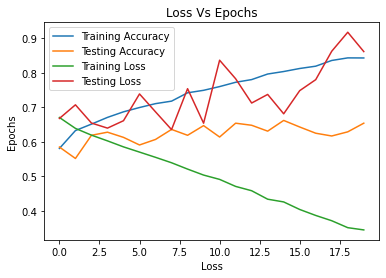

In [23]:
model_train(loss_fn, optimizer)

In [34]:
def predict_image( img, model):
    x = img.unsqueeze(0)
    y = model(x)
    
    pred = torch.argmax(y, dim=1)
    if pred == 0:
        pred = "cat"
    elif pred == 1:
        pred = "dog"
    
    return pred

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Label: cat


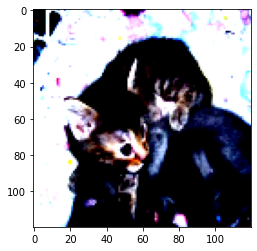

In [35]:
img, label = train_data[10]
plt.imshow(img.permute(1,2,0))
print( "Predicted Label:", predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Label: cat


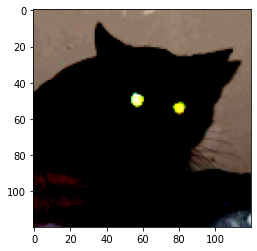

In [36]:
img, label = train_data[40]
plt.imshow(img.permute(1,2,0))
print( "Predicted Label:", predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Label: cat


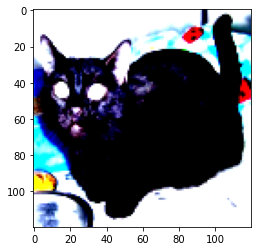

In [37]:
img, label = train_data[100]
plt.imshow(img.permute(1,2,0))
print( "Predicted Label:", predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Label: dog


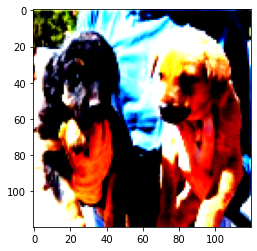

In [38]:
img, label = train_data[4000]
plt.imshow(img.permute(1,2,0))
print( "Predicted Label:", predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Label: cat


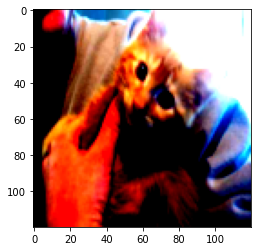

In [39]:
img, label = train_data[5000]
plt.imshow(img.permute(1,2,0))
print( "Predicted Label:", predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Label: cat


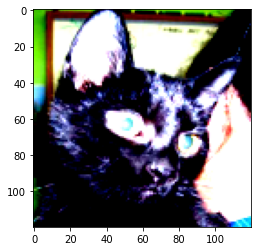

In [41]:
img, label = train_data[8989]
plt.imshow(img.permute(1,2,0))
print( "Predicted Label:", predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Label: dog


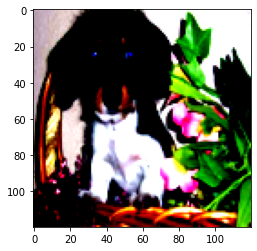

In [42]:
img, label = train_data[1840]
plt.imshow(img.permute(1,2,0))
print( "Predicted Label:", predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Label: dog


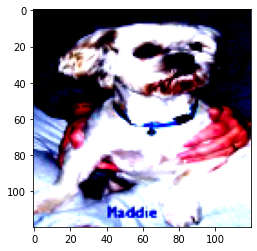

In [43]:
img, label = train_data[1730]
plt.imshow(img.permute(1,2,0))
print( "Predicted Label:", predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Label: cat


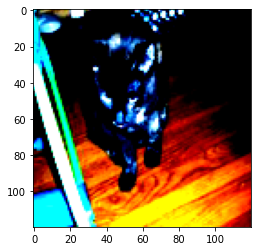

In [44]:
img, label = train_data[1876]
plt.imshow(img.permute(1,2,0))
print( "Predicted Label:", predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Label: dog


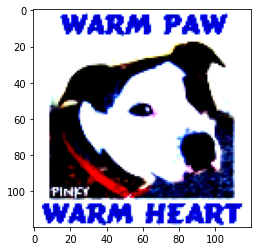

In [45]:
img, label = train_data[1567]
plt.imshow(img.permute(1,2,0))
print( "Predicted Label:", predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Label: cat


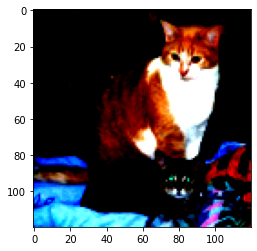

In [46]:
img, label = train_data[1345]
plt.imshow(img.permute(1,2,0))
print( "Predicted Label:", predict_image(img, model))